## Task 3: Global Temperature Changes for 1pctCO2

Goal is to preprocess the global temperature data for 1pctCO2. This model shows the scenario of which CO2 concentration increases by 1% each year. In this process, we don't have to look at any models except for 1pctCO2.

In [1]:
#imports
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

activity_id institution_id     source_id       experiment_id member_id  \
0  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
1  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
2  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
3  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   
4  HighResMIP           CMCC  CMCC-CM2-HR4  highresSST-present  r1i1p1f1   

  table_id variable_id grid_label  \
0     Amon          ps         gn   
1     Amon        rsds         gn   
2     Amon        rlus         gn   
3     Amon        rlds         gn   
4     Amon         psl         gn   

                                              zstore  dcpp_init_year   version  
0  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
1  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
2  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
3  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706  
4  gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...             NaN  20170706

In [3]:
def load_zarr_dset(df):
  # get the path to a specific zarr store (the first one from the dataframe above)
  zstore = df.zstore.values[-1]

  # create a mutable-mapping-style interface to the store
  mapper = gcs.get_mapper(zstore)

  # open it using xarray and zarr
  ds = xr.open_zarr(mapper, consolidated=True)
  return ds

In [4]:
gcs = gcsfs.GCSFileSystem(token='anon')

In [5]:
#time index to assign model times to
new_time_index=pd.date_range('1850-01-01', '1999-12-31', freq='ME')
new_time_index

DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '1999-03-31', '1999-04-30', '1999-05-31', '1999-06-30',
               '1999-07-31', '1999-08-31', '1999-09-30', '1999-10-31',
               '1999-11-30', '1999-12-31'],
              dtype='datetime64[ns]', length=1800, freq='ME')

In [6]:
#query tas models that are for 1pctCO2
df_tas_1pctCO2 = df.query ("activity_id == 'CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")
models_tas_1pctCO2 = set(df_tas_1pctCO2['source_id'])
source_list = list(models_tas_1pctCO2)
print(len(source_list))

59


In [7]:
df_tas_1pctCO2 = df.query ("activity_id == 'CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2' & member_id == 'r1i1p1f1'")
models_tas_1pctCO2 = set(df_tas_1pctCO2['source_id'])
source_list = list(models_tas_1pctCO2)
print(len(source_list))

50


In [8]:
missing_time_list = ['CESM2-FV2',
                     'NorCPM1',
                     'E3SM-1-0',
                    'CMCC-CM2-HR4',
                    'GFDL-CM4',
                    'NorESM2-MM',
                      'CESM2',
                      'ACCESS-CM2',
                      'CESM2-WACCM-FV2',
                     'CAMS-CSM1-0',
                     'ACCESS-ESM1-5',
                     'GISS-E2-2-H',
                     'FIO-ESM-2-0',
                      'CIESM',
                      'TaiESM1',
                      'CAS-ESM2-0',
                     'FGOALS-g3',
                      'MCM-UA-1-0',
                      'GFDL-ESM4',
                      'CESM2-WACCM',
                      'NorESM2-LM',
                      'IITM-ESM',
                    'MIROC6']

In [9]:
#looking at ICON-ESM-LR
df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == 'ICON-ESM-LR' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2' & member_id == 'r1i1p1f1'")
ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
ds_tas_1pctCO2

<xarray.Dataset>
Dimensions:             (i: 20480, time: 2040, bnds: 2, vertices: 3)
Coordinates:
    height              float64 ...
  * i                   (i) int32 0 1 2 3 4 5 ... 20475 20476 20477 20478 20479
    latitude            (i) float64 dask.array<chunksize=(20480,), meta=np.ndarray>
    longitude           (i) float64 dask.array<chunksize=(20480,), meta=np.ndarray>
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2019-12...
    time_bnds           (time, bnds) datetime64[ns] dask.array<chunksize=(2040, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    tas                 (time, i) float32 dask.array<chunksize=(896, 20480), meta=np.ndarray>
    vertices_latitude   (i, vertices) float64 dask.array<chunksize=(20480, 3), meta=np.ndarray>
    vertices_longitude  (i, vertices) float64 dask.array<chunksize=(20480, 3), meta=np.ndarray>
Attributes: (12/53)
    CDI_grid_type:          unstructured
    CDO:                    Climate Data Operators version 2.0.0rc5 (https://...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    ...                     ...
    table_info:             Creation Date:(09 May 2019) MD5:5f007c16960eee824...
    title:                  ICON-ESM-LR output prepared for CMIP6
    tracking_id:            hdl:21.14100/486e27d0-6de0-4dfc-b337-b45b250116b7
    variable_id:            tas
    variant_label:          r1i1p1f1
    version_id:             v20210215

In [10]:
for source in missing_time_list:
    if source in source_list:
        source_list.remove(source)

#remove ICON-ESM-LR, decided to remove because lat and lon depend on i dimension, hard to convert i to lat and lon
source_list.remove('ICON-ESM-LR')

In [11]:
print(len(source_list))

26


In [12]:
source_list

['CanESM5',
 'GISS-E2-1-G',
 'INM-CM5-0',
 'EC-Earth3-Veg',
 'KIOST-ESM',
 'GISS-E2-1-H',
 'MPI-ESM1-2-HR',
 'KACE-1-0-G',
 'MPI-ESM1-2-LR',
 'BCC-ESM1',
 'EC-Earth3-AerChem',
 'IPSL-CM5A2-INCA',
 'NESM3',
 'AWI-CM-1-1-MR',
 'INM-CM4-8',
 'GISS-E2-2-G',
 'CMCC-ESM2',
 'FGOALS-f3-L',
 'CMCC-CM2-SR5',
 'BCC-CSM2-MR',
 'SAM0-UNICON',
 'MRI-ESM2-0',
 'MPI-ESM-1-2-HAM',
 'EC-Earth3-CC',
 'AWI-ESM-1-1-LR',
 'IPSL-CM6A-LR']

### 1.1 Loading One Model 

In [102]:
#access data
df_tas_1pctCO2_nesm3 = df.query("activity_id == 'CMIP' & source_id == 'NESM3' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2' & member_id == 'r1i1p1f1'")
ds_tas_1pctCO2_nesm3 = load_zarr_dset(df_tas_1pctCO2_nesm3)
#load temperature data
tas_1pct_nesm3 = ds_tas_1pctCO2_nesm3.tas
#weights of the area of the grid cells
weight_nesm3 = np.cos(np.deg2rad(tas_1pct_nesm3.lat))
ds_tas_1pctCO2_nesm3_w_mean = tas_1pct_nesm3.weighted(weight_nesm3).mean(dim=('lon', 'lat'))
ds_tas_1pctCO2_nesm3_w_mean

<xarray.DataArray 'tas' (time: 1800)>
dask.array<truediv, shape=(1800,), dtype=float64, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 1999-12-16T12:00:00

Text(0.5, 1.0, 'NESM3 Global Mean Temperature')

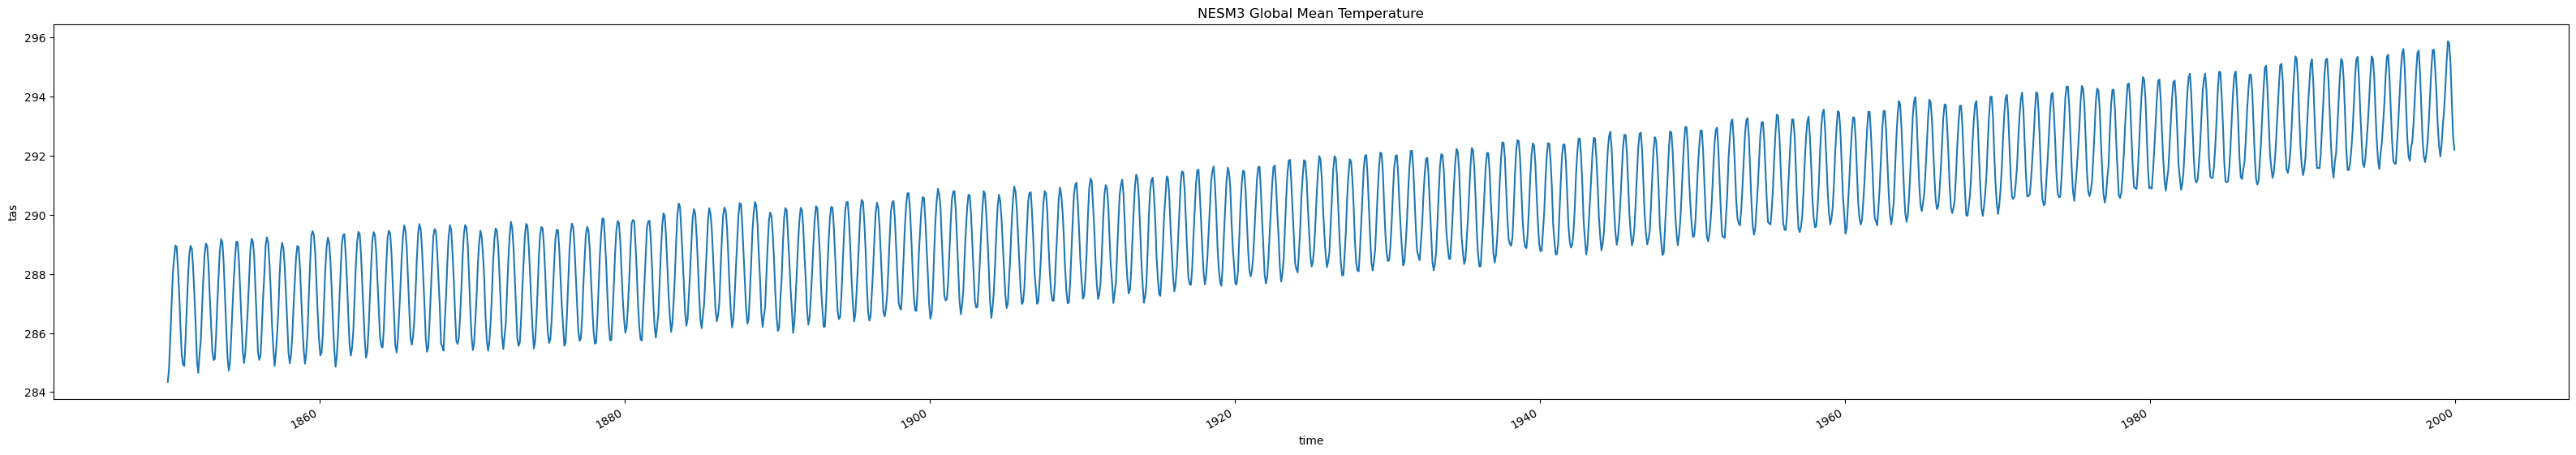

In [12]:
fig, ax = plt.subplots(figsize = (40,6))
ds_tas_1pctCO2_nesm3_w_mean.plot(ax=ax)
plt.title("NESM3 Global Mean Temperature")

### Adding in 9 Models

In [13]:
ds_9_models_list = list()
#query to individual model
df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == 'CanESM5-CanOE' & member_id == 'r1i1p2f1' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")
ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
#slice first and then assign
tas = ds_tas_1pctCO2.isel(time = slice(0,1800))
ds = tas.assign(time=new_time_index)
ds = ds.assign_coords(model=ds_tas_1pctCO2.source_id)           
#weights of the area of the grid cells
weight = np.cos(np.deg2rad(ds_tas_1pctCO2.tas.lat))
ds_all = ds.weighted(weight).mean(dim=('lon','lat'))
#add to list
ds_9_models_list.append(ds_all)
print(ds_all.coords)

Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U13 'CanESM5-CanOE'


In [14]:
#query to individual model
df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == 'UKESM1-0-LL' & member_id == 'r1i1p1f2' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")
ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
#slice first and then assign
#print(ds_tas_1pctCO2.time[0])
#print(ds_tas_1pctCO2.time[-1])
tas = ds_tas_1pctCO2.isel(time = slice(0,1800))
ds = tas.assign(time=new_time_index)
ds = ds.assign_coords(model=ds_tas_1pctCO2.source_id)           
#weights of the area of the grid cells
weight = np.cos(np.deg2rad(ds_tas_1pctCO2.tas.lat))
ds_all = ds.weighted(weight).mean(dim=('lon','lat'))
#add to list
ds_9_models_list.append(ds_all)
print(ds_all.coords)

Coordinates:
    height   float64 1.5
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U11 'UKESM1-0-LL'


In [15]:
df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == 'CNRM-CM6-1' & member_id == 'r1i1p1f2' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")
ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
#slice first and then assign
#print(ds_tas_1pctCO2.time[0])
#print(ds_tas_1pctCO2.time[-1])
tas = ds_tas_1pctCO2.isel(time = slice(0,1800))
ds = tas.assign(time=new_time_index)
ds = ds.assign_coords(model=ds_tas_1pctCO2.source_id)           
#weights of the area of the grid cells
weight = np.cos(np.deg2rad(ds_tas_1pctCO2.tas.lat))
ds_all = ds.weighted(weight).mean(dim=('lon','lat'))
#add to list
ds_9_models_list.append(ds_all)
print(ds_all.coords)

Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U10 'CNRM-CM6-1'


In [16]:
df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == 'MIROC-ES2L' & member_id == 'r1i1p1f2' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")
ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
#slice first and then assign
#print(ds_tas_1pctCO2.time[0])
#print(ds_tas_1pctCO2.time[-1])
tas = ds_tas_1pctCO2.isel(time = slice(0,1800))
ds = tas.assign(time=new_time_index)
ds = ds.assign_coords(model=ds_tas_1pctCO2.source_id)           
#weights of the area of the grid cells
weight = np.cos(np.deg2rad(ds_tas_1pctCO2.tas.lat))
ds_all = ds.weighted(weight).mean(dim=('lon','lat'))
#add to list
ds_9_models_list.append(ds_all)
print(ds_all.coords)

Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U10 'MIROC-ES2L'


In [17]:
df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == 'CNRM-CM6-1-HR' & member_id == 'r1i1p1f2' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")
ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
#slice first and then assign
#print(ds_tas_1pctCO2.time[0])
#print(ds_tas_1pctCO2.time[-1])
tas = ds_tas_1pctCO2.isel(time = slice(0,1800))
ds = tas.assign(time=new_time_index)
ds = ds.assign_coords(model=ds_tas_1pctCO2.source_id)           
#weights of the area of the grid cells
weight = np.cos(np.deg2rad(ds_tas_1pctCO2.tas.lat))
ds_all = ds.weighted(weight).mean(dim=('lon','lat'))
#add to list
ds_9_models_list.append(ds_all)
print(ds_all.coords)

Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U13 'CNRM-CM6-1-HR'


In [18]:
df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == 'HadGEM3-GC31-LL' & member_id == 'r1i1p1f3' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")
ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
#slice first and then assign
#print(ds_tas_1pctCO2.time[0])
#print(ds_tas_1pctCO2.time[-1])
tas = ds_tas_1pctCO2.isel(time = slice(0,1800))
ds = tas.assign(time=new_time_index)
ds = ds.assign_coords(model=ds_tas_1pctCO2.source_id)           
#weights of the area of the grid cells
weight = np.cos(np.deg2rad(ds_tas_1pctCO2.tas.lat))
ds_all = ds.weighted(weight).mean(dim=('lon','lat'))
#add to list
ds_9_models_list.append(ds_all)
print(ds_all.coords)

Coordinates:
    height   float64 1.5
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U15 'HadGEM3-GC31-LL'


In [19]:
df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == 'EC-Earth3' & member_id == 'r3i1p1f1' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")
ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
#slice first and then assign
#print(ds_tas_1pctCO2.time[0])
#print(ds_tas_1pctCO2.time[-1])
tas = ds_tas_1pctCO2.isel(time = slice(0,1800))
ds = tas.assign(time=new_time_index)
ds = ds.assign_coords(model=ds_tas_1pctCO2.source_id)           
#weights of the area of the grid cells
weight = np.cos(np.deg2rad(ds_tas_1pctCO2.tas.lat))
ds_all = ds.weighted(weight).mean(dim=('lon','lat'))
#add to list
ds_9_models_list.append(ds_all)
print(ds_all.coords)

Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U9 'EC-Earth3'


In [20]:
df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == 'CNRM-ESM2-1' & member_id == 'r1i1p1f2' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")
ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
#slice first and then assign
#print(ds_tas_1pctCO2.time[0])
#print(ds_tas_1pctCO2.time[-1])
tas = ds_tas_1pctCO2.isel(time = slice(0,1800))
ds = tas.assign(time=new_time_index)
ds= ds.assign_coords(model=ds_tas_1pctCO2.source_id)           
#weights of the area of the grid cells
weight = np.cos(np.deg2rad(ds_tas_1pctCO2.tas.lat))
ds_all = ds.weighted(weight).mean(dim=('lon','lat'))
#add to list
ds_9_models_list.append(ds_all)

In [21]:
df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == 'HadGEM3-GC31-MM' & member_id == 'r1i1p1f3' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2'")
ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
#slice first and then assign
#print(ds_tas_1pctCO2.time[0])
#print(ds_tas_1pctCO2.time[-1])
tas = ds_tas_1pctCO2.isel(time = slice(0,1812))
ds = tas.assign(time=new_time_index)
ds = ds.assign_coords(model=ds_tas_1pctCO2.source_id)           
#weights of the area of the grid cells
weight = np.cos(np.deg2rad(ds_tas_1pctCO2.tas.lat))
ds_all = ds.weighted(weight).mean(dim=('lon','lat'))
#add to list
ds_9_models_list.append(ds_all)

In [22]:
ds_9_models = xr.concat(ds_9_models_list, dim = 'model', coords = 'minimal',compat='override')
ds_9_models

<xarray.Dataset>
Dimensions:  (time: 1800, model: 9)
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
  * model    (model) <U15 'CanESM5-CanOE' 'UKESM1-0-LL' ... 'HadGEM3-GC31-MM'
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>

### 1.2 Load Multiple Models


In [23]:
gcm_list = ['EC-Earth3-CC',
 'NESM3',
 'CanESM5',
 'IPSL-CM6A-LR',
 'MPI-ESM-1-2-HAM']

In [24]:
#ICON-ESM-LR does not recognize lat/lon as dimensions... trying to fix this
#renaming it did not help like previously so i have to create is own dimension for it

#bfore we concat the data and merged them by time but now we cant do that

In [25]:
ds_list = list()
for source in gcm_list:
    df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2' & member_id == 'r1i1p1f1'")
    ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
    #check coords
    print("\n"+source)
    #print(ds_tas_1pctCO2.coords)
    #doesn't recognize latitude and longitude as coordinates
    #if source == 'ICON-ESM-LR':
        #ds_tas_1pctCO2 = ds_tas_1pctCO2.rename({'latitude': 'lat', 'longitude': 'lon'})
    #calculate weighted mean
    #weights
    weight = np.cos(np.deg2rad(ds_tas_1pctCO2.lat))
    ds_all = ds_tas_1pctCO2.weighted(weight).mean(dim=('lon', 'lat'))
    #slice_and assign new time index
    ds_all = ds_all.isel(time=slice(0, 1800))
    ds_all = ds_all.assign_coords(model=source)
    #to fix compatability calendar error
    ds_all = ds_all.assign(time=new_time_index)    
    print(ds_all.coords)
    #Append to list
    ds_list.append(ds_all)
#Concatenate datasets along 'model' dimension
ob_all_gcm = xr.concat(ds_list, dim='model', coords='minimal', compat='override')
ob_all_gcm


EC-Earth3-CC
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U12 'EC-Earth3-CC'

NESM3
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U5 'NESM3'

CanESM5
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U7 'CanESM5'

IPSL-CM6A-LR
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U12 'IPSL-CM6A-LR'

MPI-ESM-1-2-HAM
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U15 'MPI-ESM-1-2-HAM'


<xarray.Dataset>
Dimensions:  (time: 1800, model: 5)
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
  * model    (model) <U15 'EC-Earth3-CC' 'NESM3' ... 'MPI-ESM-1-2-HAM'
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 126), meta=np.ndarray>

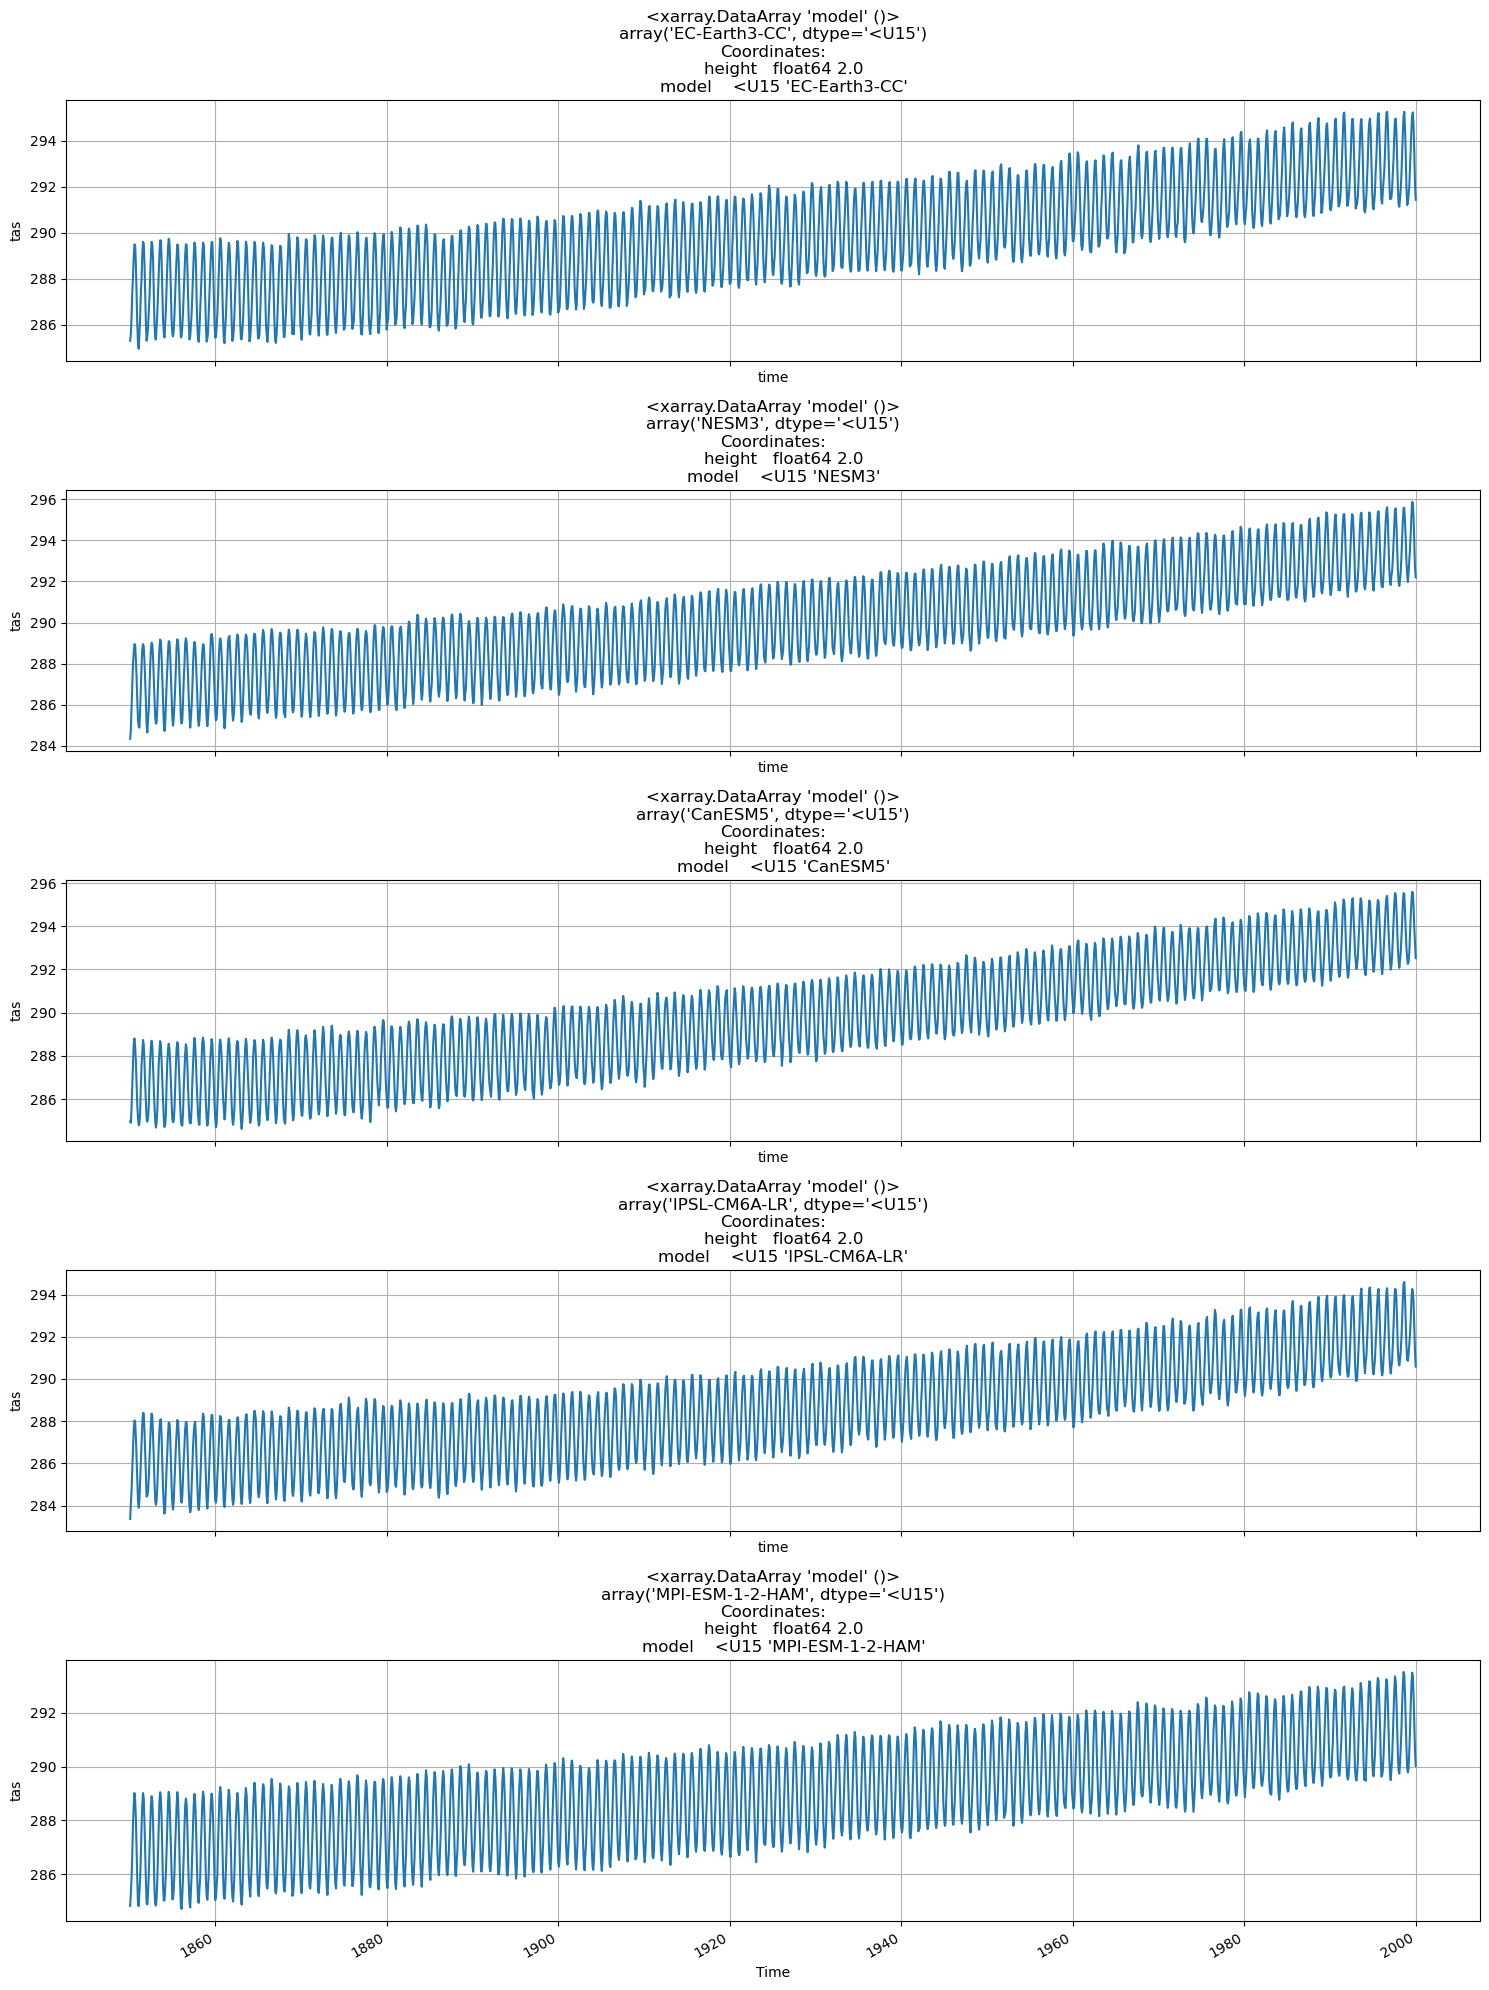

In [26]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)
for i, model in enumerate(ob_all_gcm.model): #enumerate returns iterator of pairs, each pair contains the index and the corresponding element from the iterable
    ob_all_gcm.sel(model=model).tas.plot(ax=axs[i], label=model) #selects each model and the tas variable, plots over each axes
    axs[i].set_title(model) #shows what model number
    axs[i].set_ylabel('tas')
    axs[i].grid(True) #makes gridlines on plot
axs[-1].set_xlabel('Time') 
plt.tight_layout() #creates a better layout for subplots
plt.show()

In [23]:
ds_list = list()
for source in source_list:
    df_tas_1pctCO2 = df.query("activity_id == 'CMIP' & source_id == @source & table_id == 'Amon' & variable_id == 'tas' & experiment_id == '1pctCO2' & member_id == 'r1i1p1f1'")
    ds_tas_1pctCO2 = load_zarr_dset(df_tas_1pctCO2)
    #checking time periods
    print("\n" + source)
    #print(ds_tas_1pctCO2.coords)
    #print(ds_tas_1pctCO2)

    #fixing lat/lon dimensions
    if source == 'ICON-ESM-LR':
        lat_values = ds_tas_1pctCO2.coords['latitude'].values
        lon_values = ds_tas_1pctCO2.coords['longitude'].values
        ds_tas_1pctCO2 = ds_tas_1pctCO2.assign_coords(lat=lat_values, lon=lon_values)
        ds_tas_1pctCO2 = ds_tas_1pctCO2.drop_vars('latitude')
        #ds_tas_1pctCO2 = ds_tas_1pctCO2.drop_vars('i')
        ds_tas_1pctCO2 = ds_tas_1pctCO2.drop_vars('longitude')
    #print(ds_tas_1pctCO2)
    #weighted means
    weight = np.cos(np.deg2rad(ds_tas_1pctCO2.lat))
    ds_all = ds_tas_1pctCO2.weighted(weight).mean(dim=('lon', 'lat'))
    #slice_and assign new time index
    ds_all = ds_all.isel(time=slice(0, 1800))
    ds_all = ds_all.assign_coords(model=source)
    #to fix compatability calendar error
    ds_all = ds_all.assign(time=new_time_index)    
    print(ds_all.coords)
    #append to list
    ds_list.append(ds_all)
    
ob_all = xr.concat(ds_list, dim = 'model', coords = 'minimal', compat = 'override')
ob_all



CanESM5
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U7 'CanESM5'

GISS-E2-1-G
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U11 'GISS-E2-1-G'

INM-CM5-0
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U9 'INM-CM5-0'

EC-Earth3-Veg
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U13 'EC-Earth3-Veg'

KIOST-ESM
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U9 'KIOST-ESM'

GISS-E2-1-H
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
    model    <U11 'GISS-E2-1-H'

MPI-ESM1-2-HR
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 

<xarray.Dataset>
Dimensions:  (time: 1800, model: 26)
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
  * model    (model) <U17 'CanESM5' 'GISS-E2-1-G' ... 'IPSL-CM6A-LR'
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 126), meta=np.ndarray>

In [24]:
ob_all = ob_all.drop_vars('height')
ob_all

<xarray.Dataset>
Dimensions:  (time: 1800, model: 26)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
  * model    (model) <U17 'CanESM5' 'GISS-E2-1-G' ... 'IPSL-CM6A-LR'
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 126), meta=np.ndarray>

In [25]:
ds_all_35 = xr.concat([ds_9_models, ob_all], dim = 'model', coords = 'minimal', compat = 'override')
ds_all_35 = ds_all_35.drop_vars('height')
ds_all_35

<xarray.Dataset>
Dimensions:  (time: 1800, model: 35)
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
  * model    (model) <U17 'CanESM5-CanOE' 'UKESM1-0-LL' ... 'IPSL-CM6A-LR'
Data variables:
    tas      (model, time) float64 dask.array<chunksize=(1, 96), meta=np.ndarray>

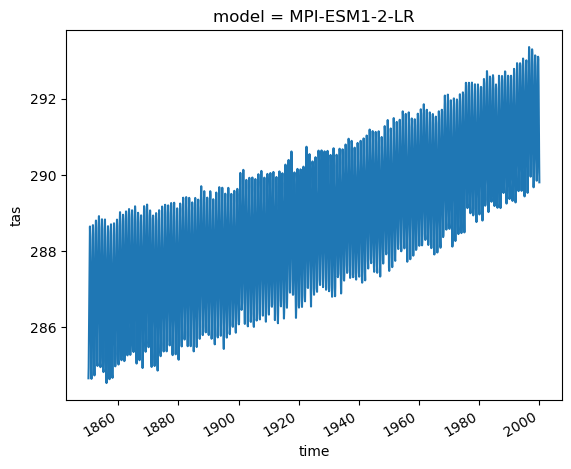

In [28]:
#checking 'MPI-ESM1-2-LR'
ob_all.sel(model = 'MPI-ESM1-2-LR').tas.plot()

### Plots for Multiple Models

In [126]:
#general fn for makes these subplots
def plot_time_series(fig_counter_input, num_subplots, model_index, dataset):
    fig, axs = plt.subplots(num_subplots, 1, figsize=(15, 20), sharex=True)
    fig_counter = fig_counter_input
    while fig_counter < (fig_counter_input + num_subplots): #made another while loop to separate the graphs and make it cleaner
        for i, model in enumerate(dataset.model[model_index:]): #sliced from 30th index after last model figure shown in previous cell block (index should be same each time in dataset)
            if fig_counter >= (fig_counter_input + num_subplots):
                break
            dataset.sel(model=model).tas.plot(ax=axs[i],label=model)
            axs[i].set_title(model) #shows what model number
            axs[i].set_ylabel('tas')
            axs[i].grid(True) #makes gridlines on plot
            fig_counter +=1
    axs[-1].set_xlabel('Time') 
    plt.tight_layout() #creates a better layout for subplots
    plt.show()

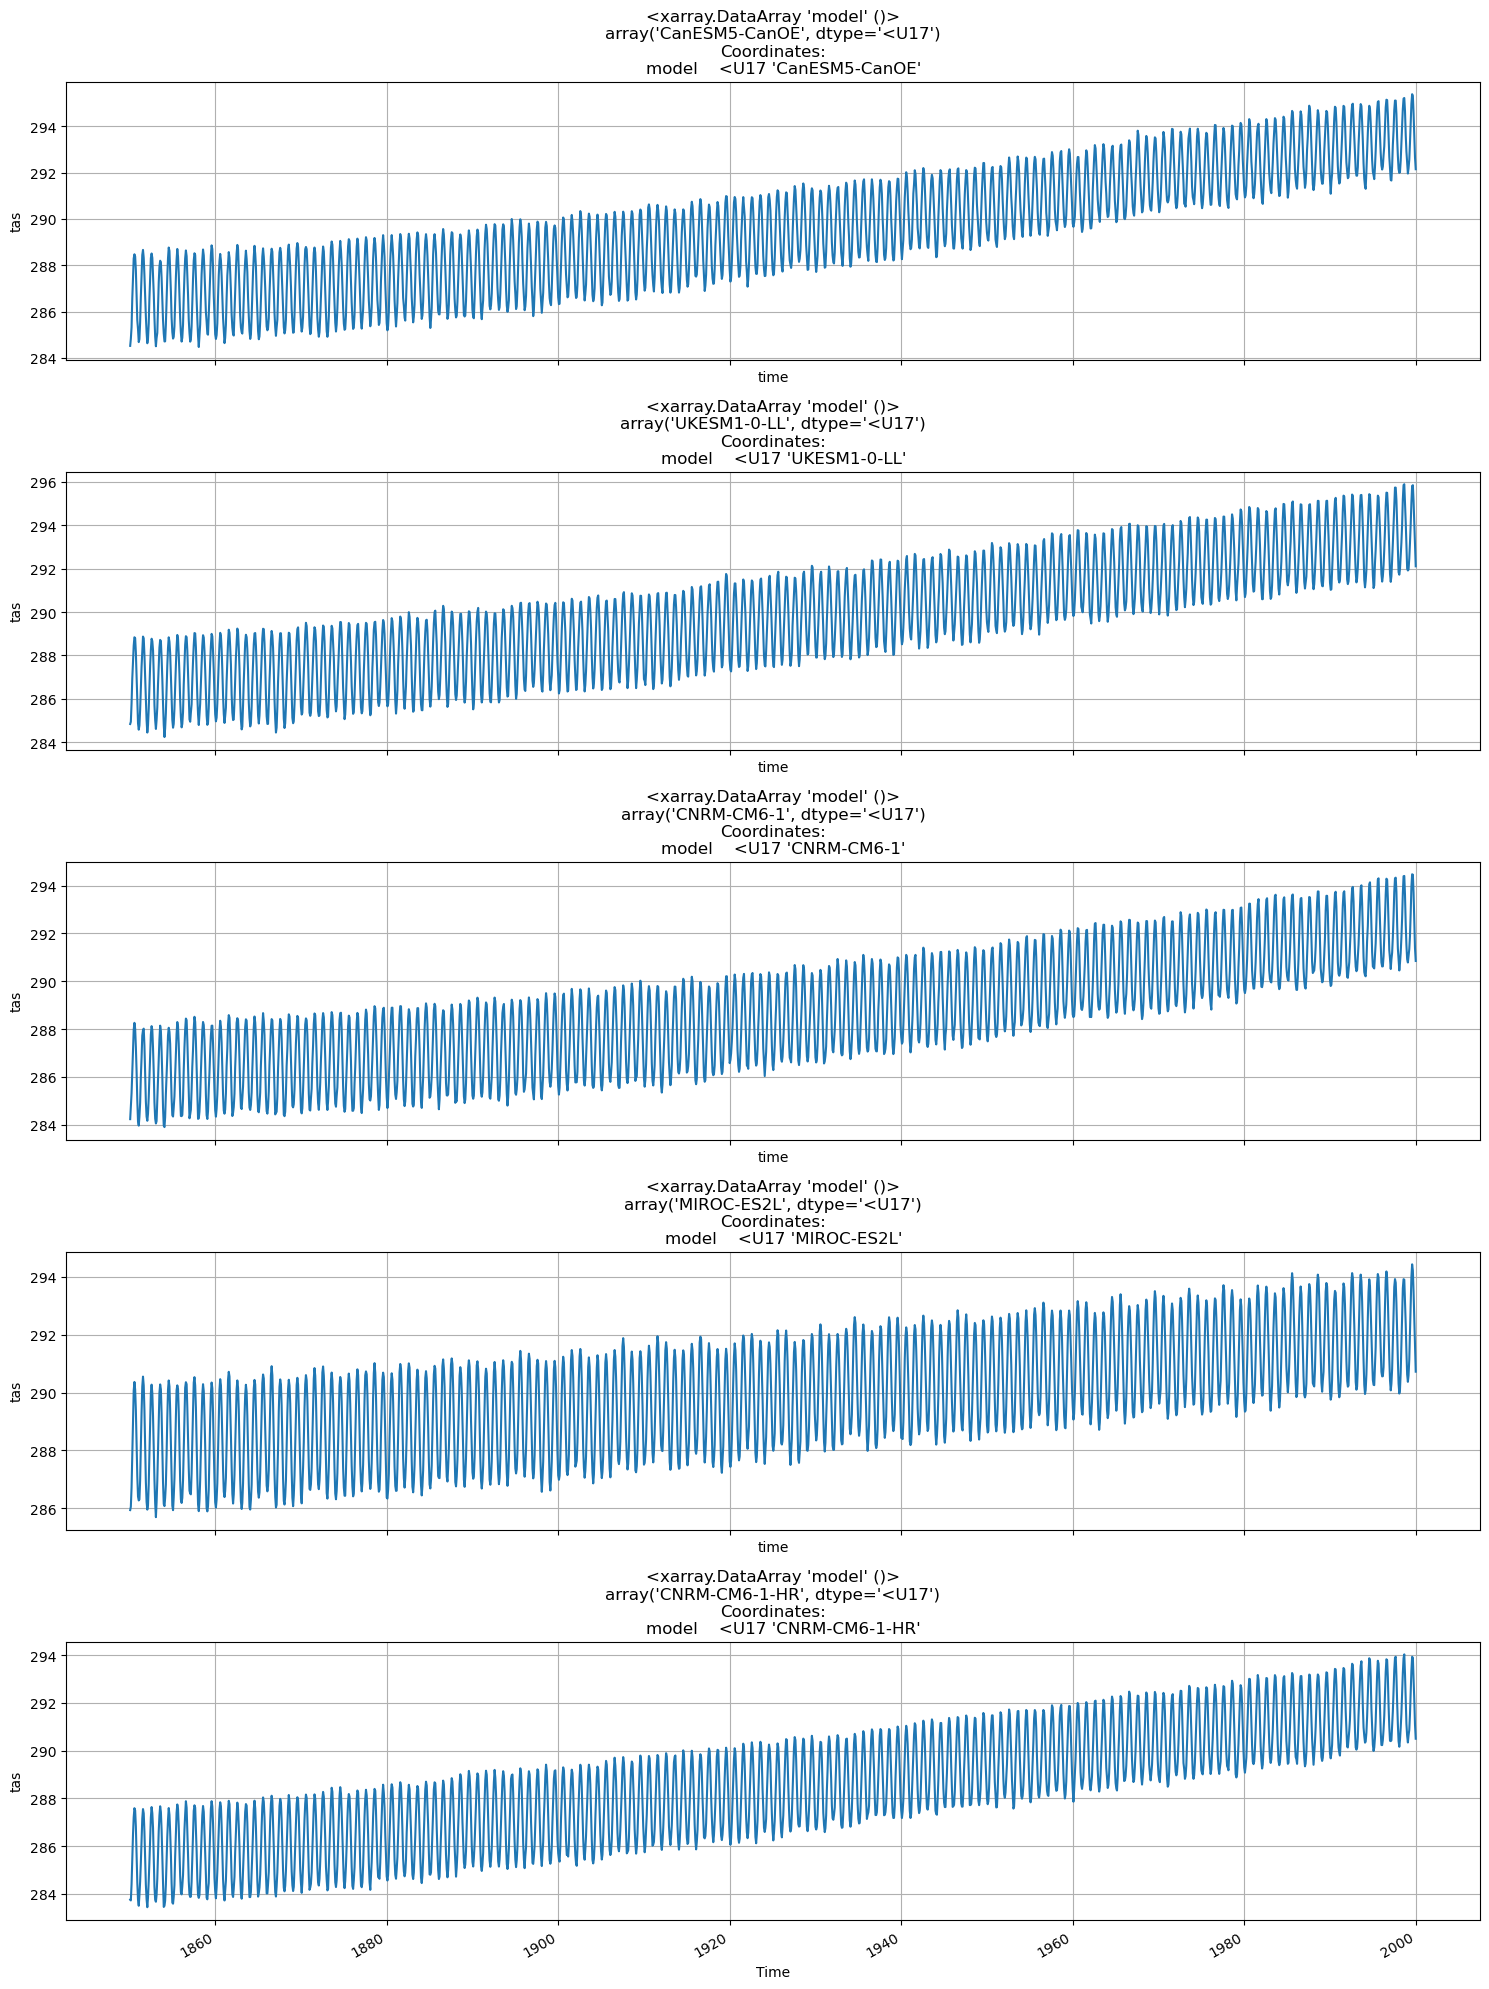

In [127]:
plot_time_series(0,5,0,ds_all_35)

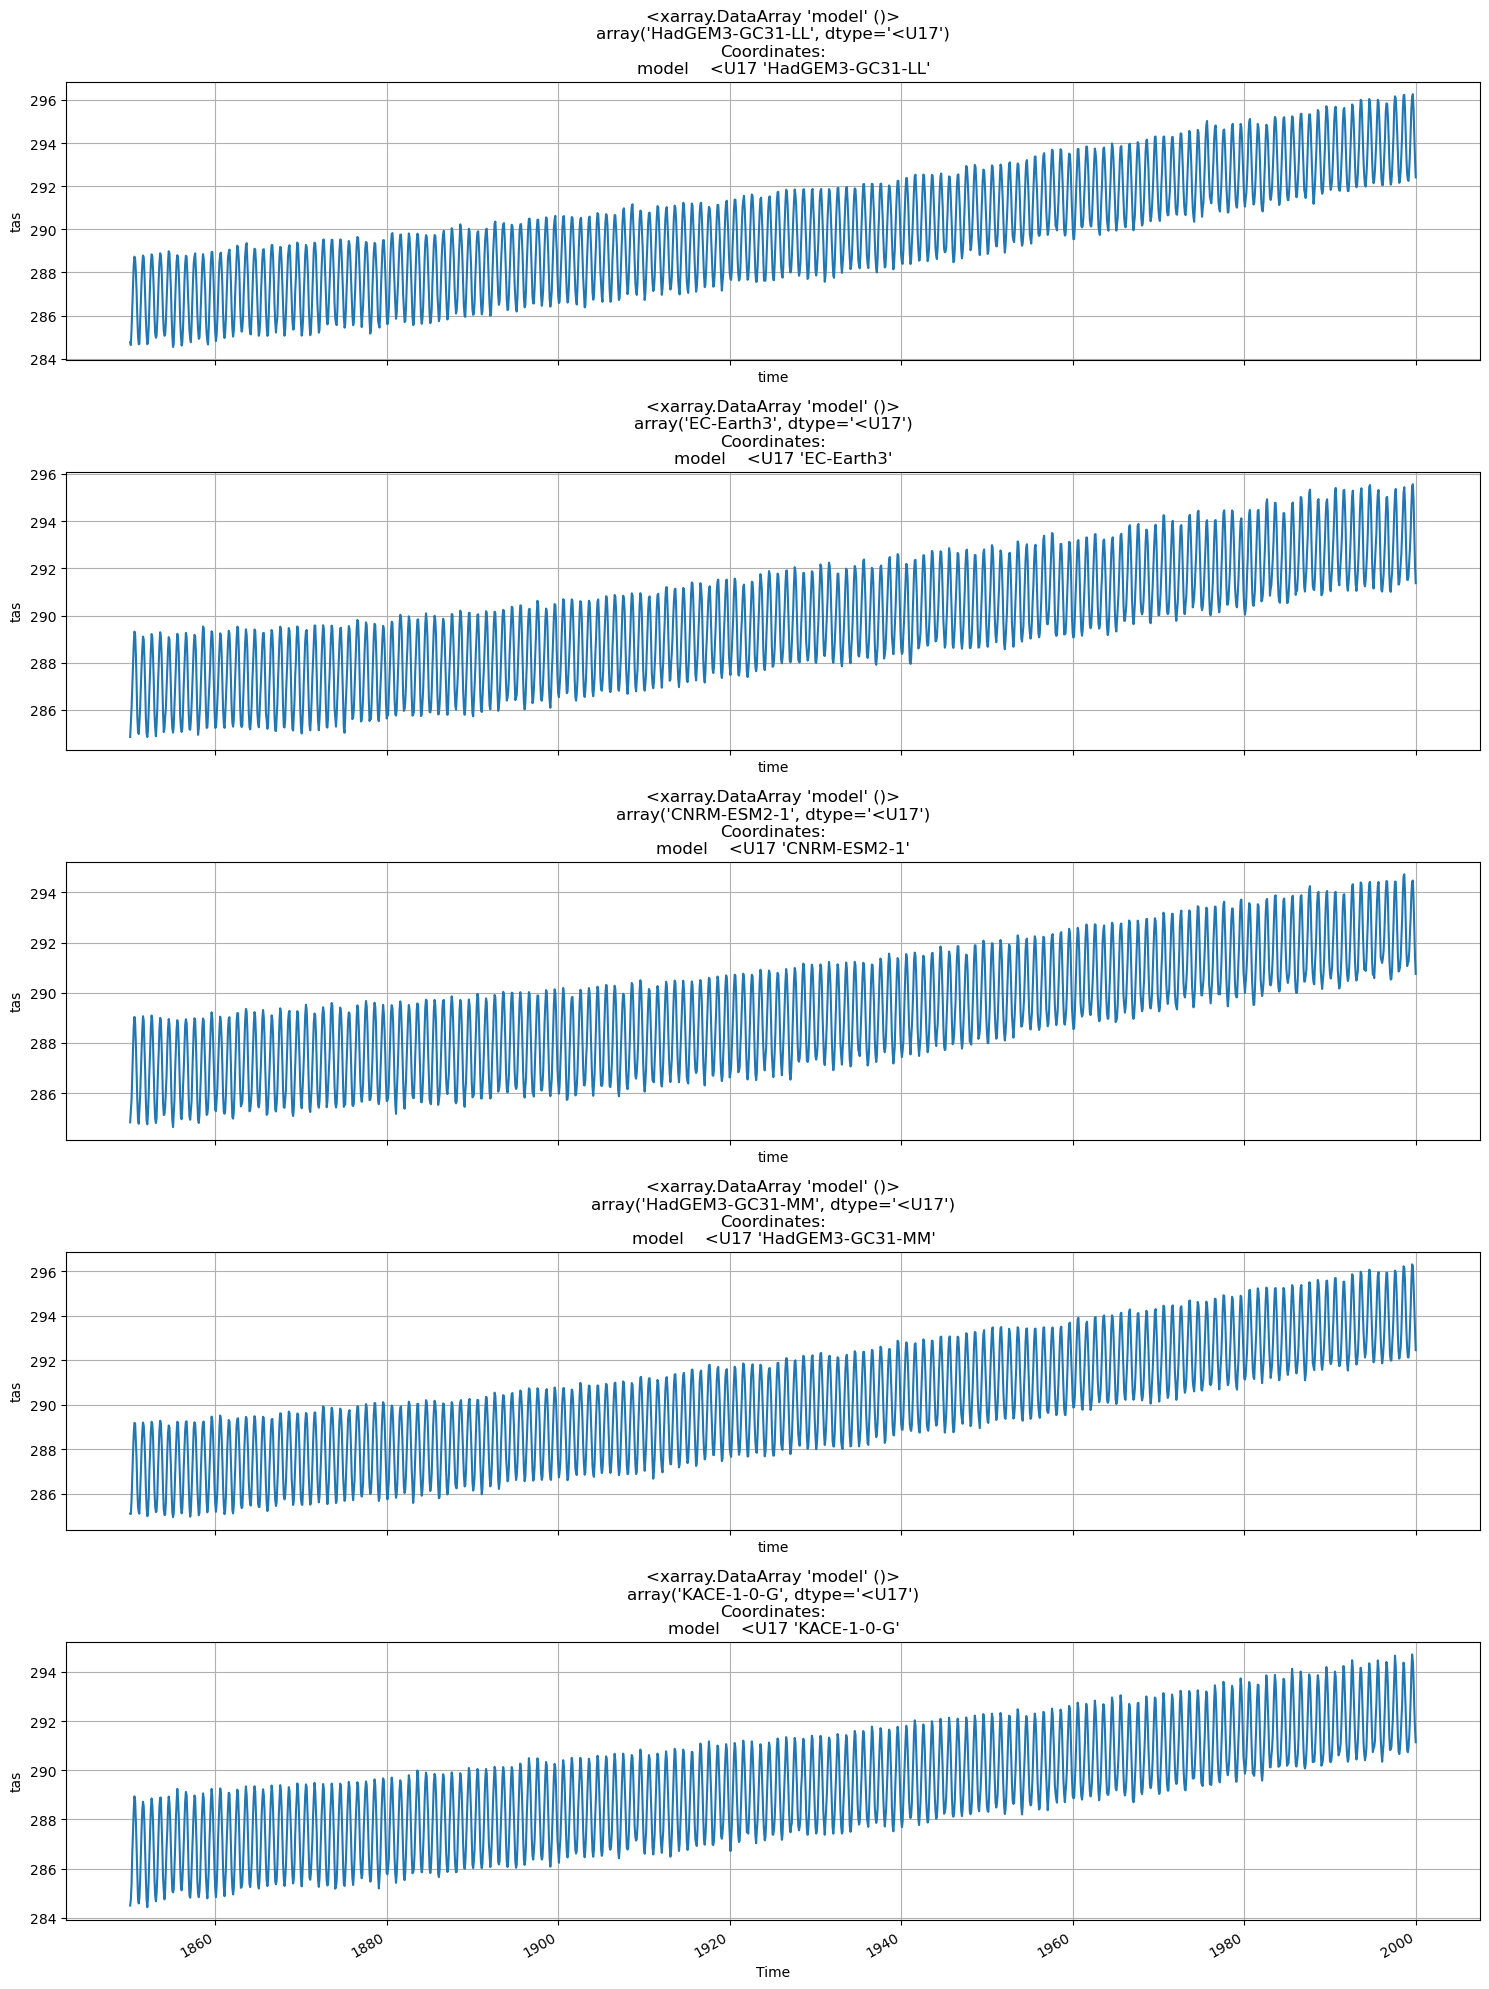

In [128]:
plot_time_series(0,5,5,ds_all_35)

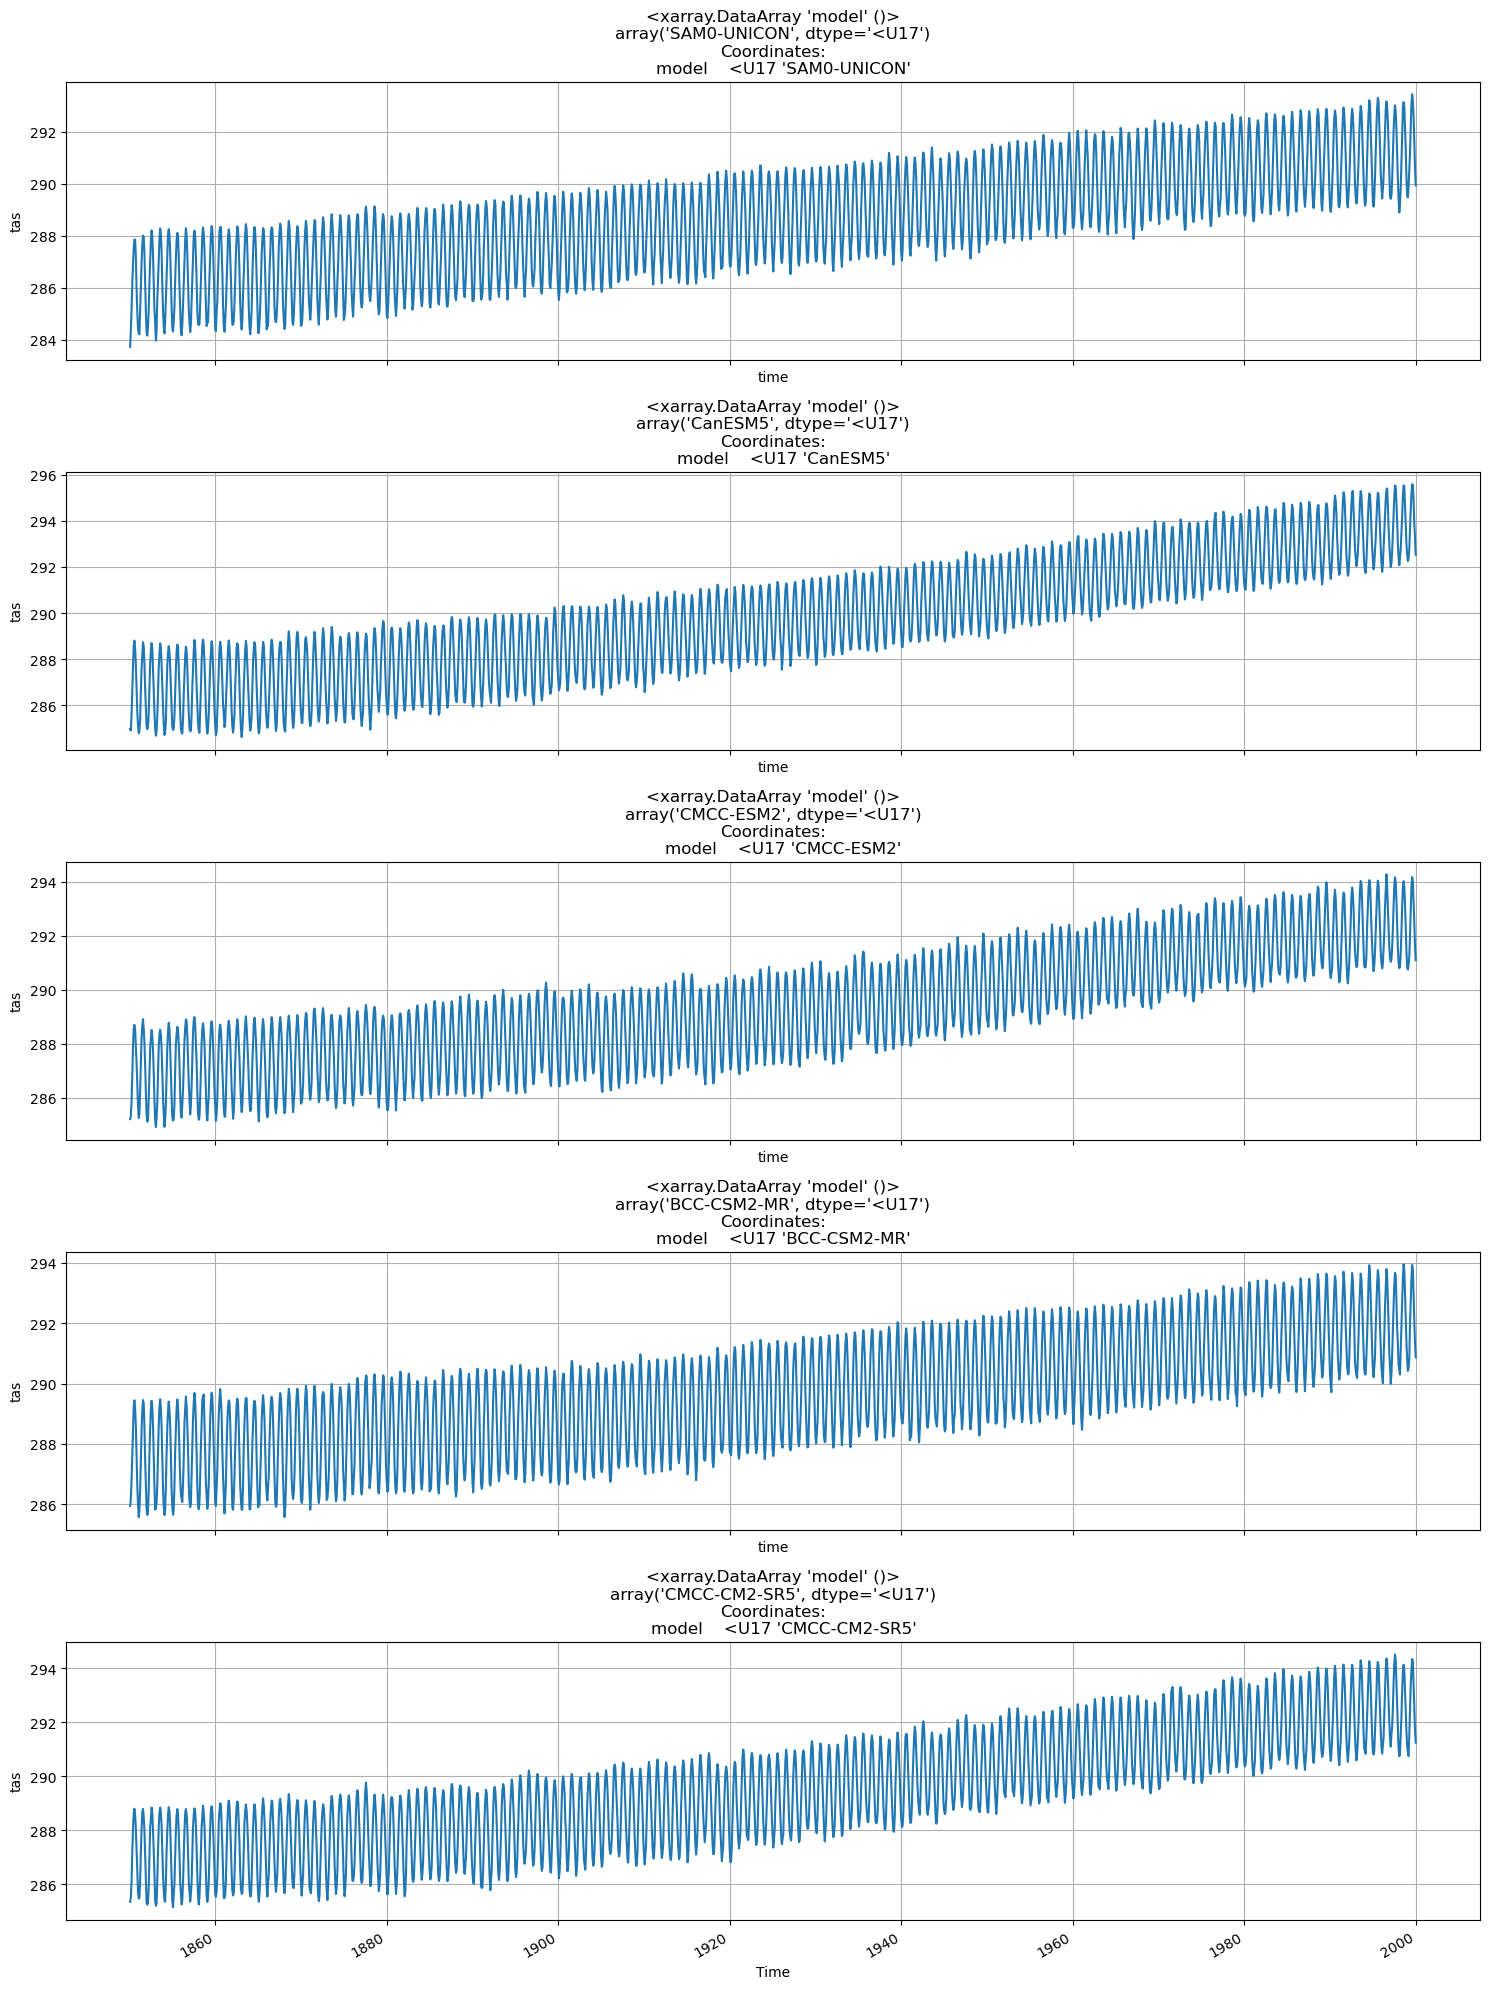

In [129]:
plot_time_series(0,5,10,ds_all_35)

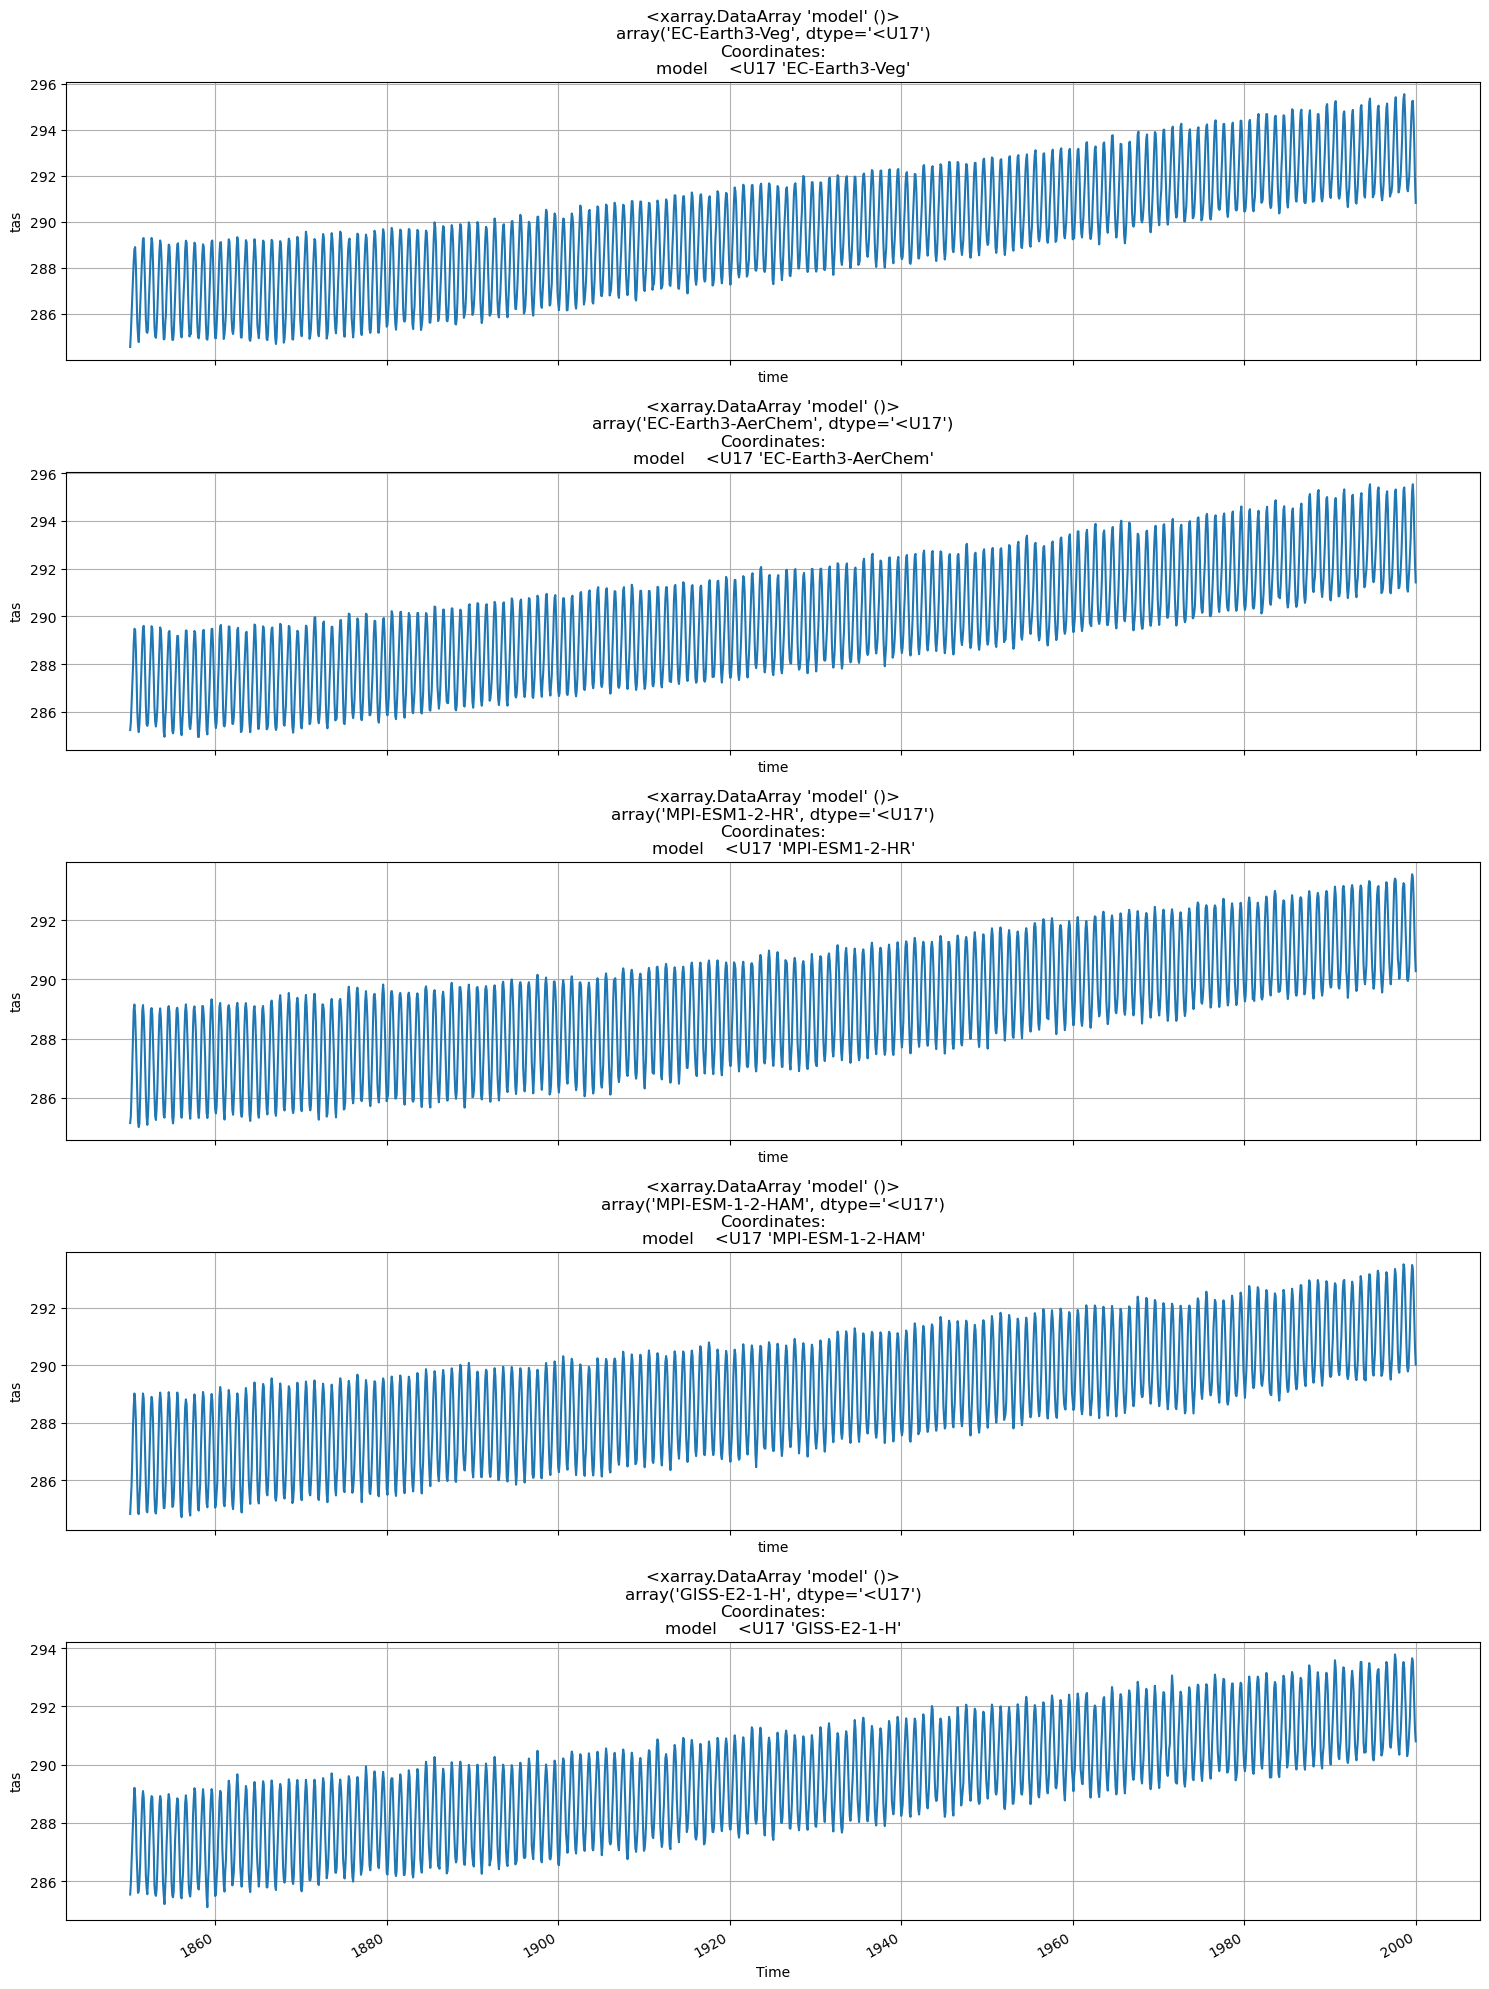

In [130]:
plot_time_series(0,5,15,ds_all_35)

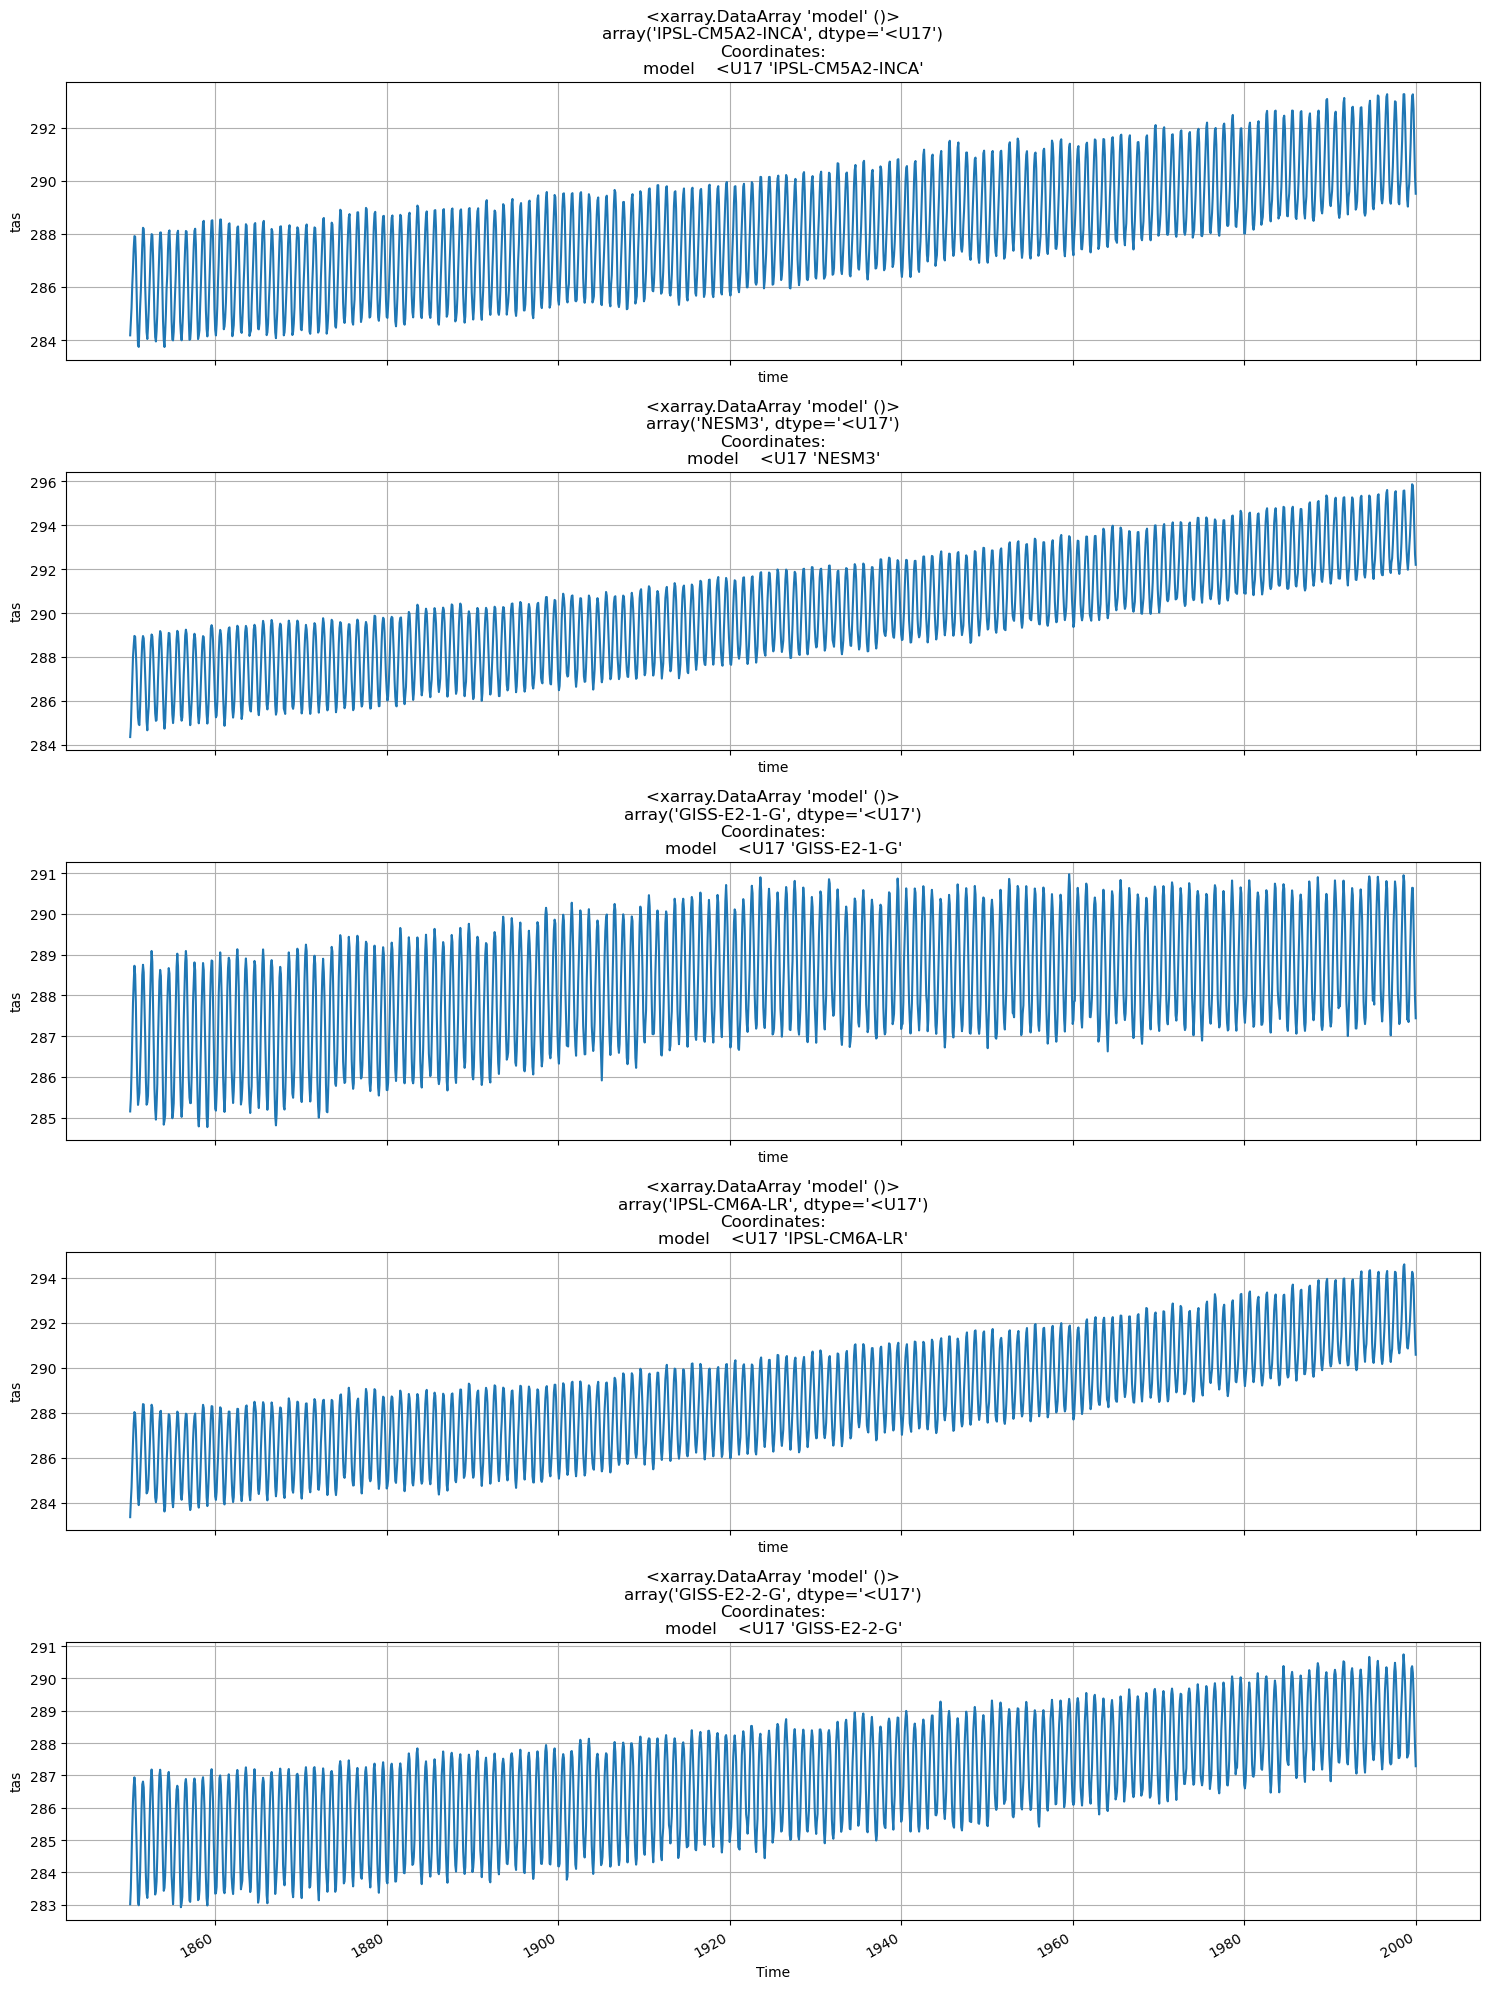

In [131]:
plot_time_series(0,5,20,ds_all_35)

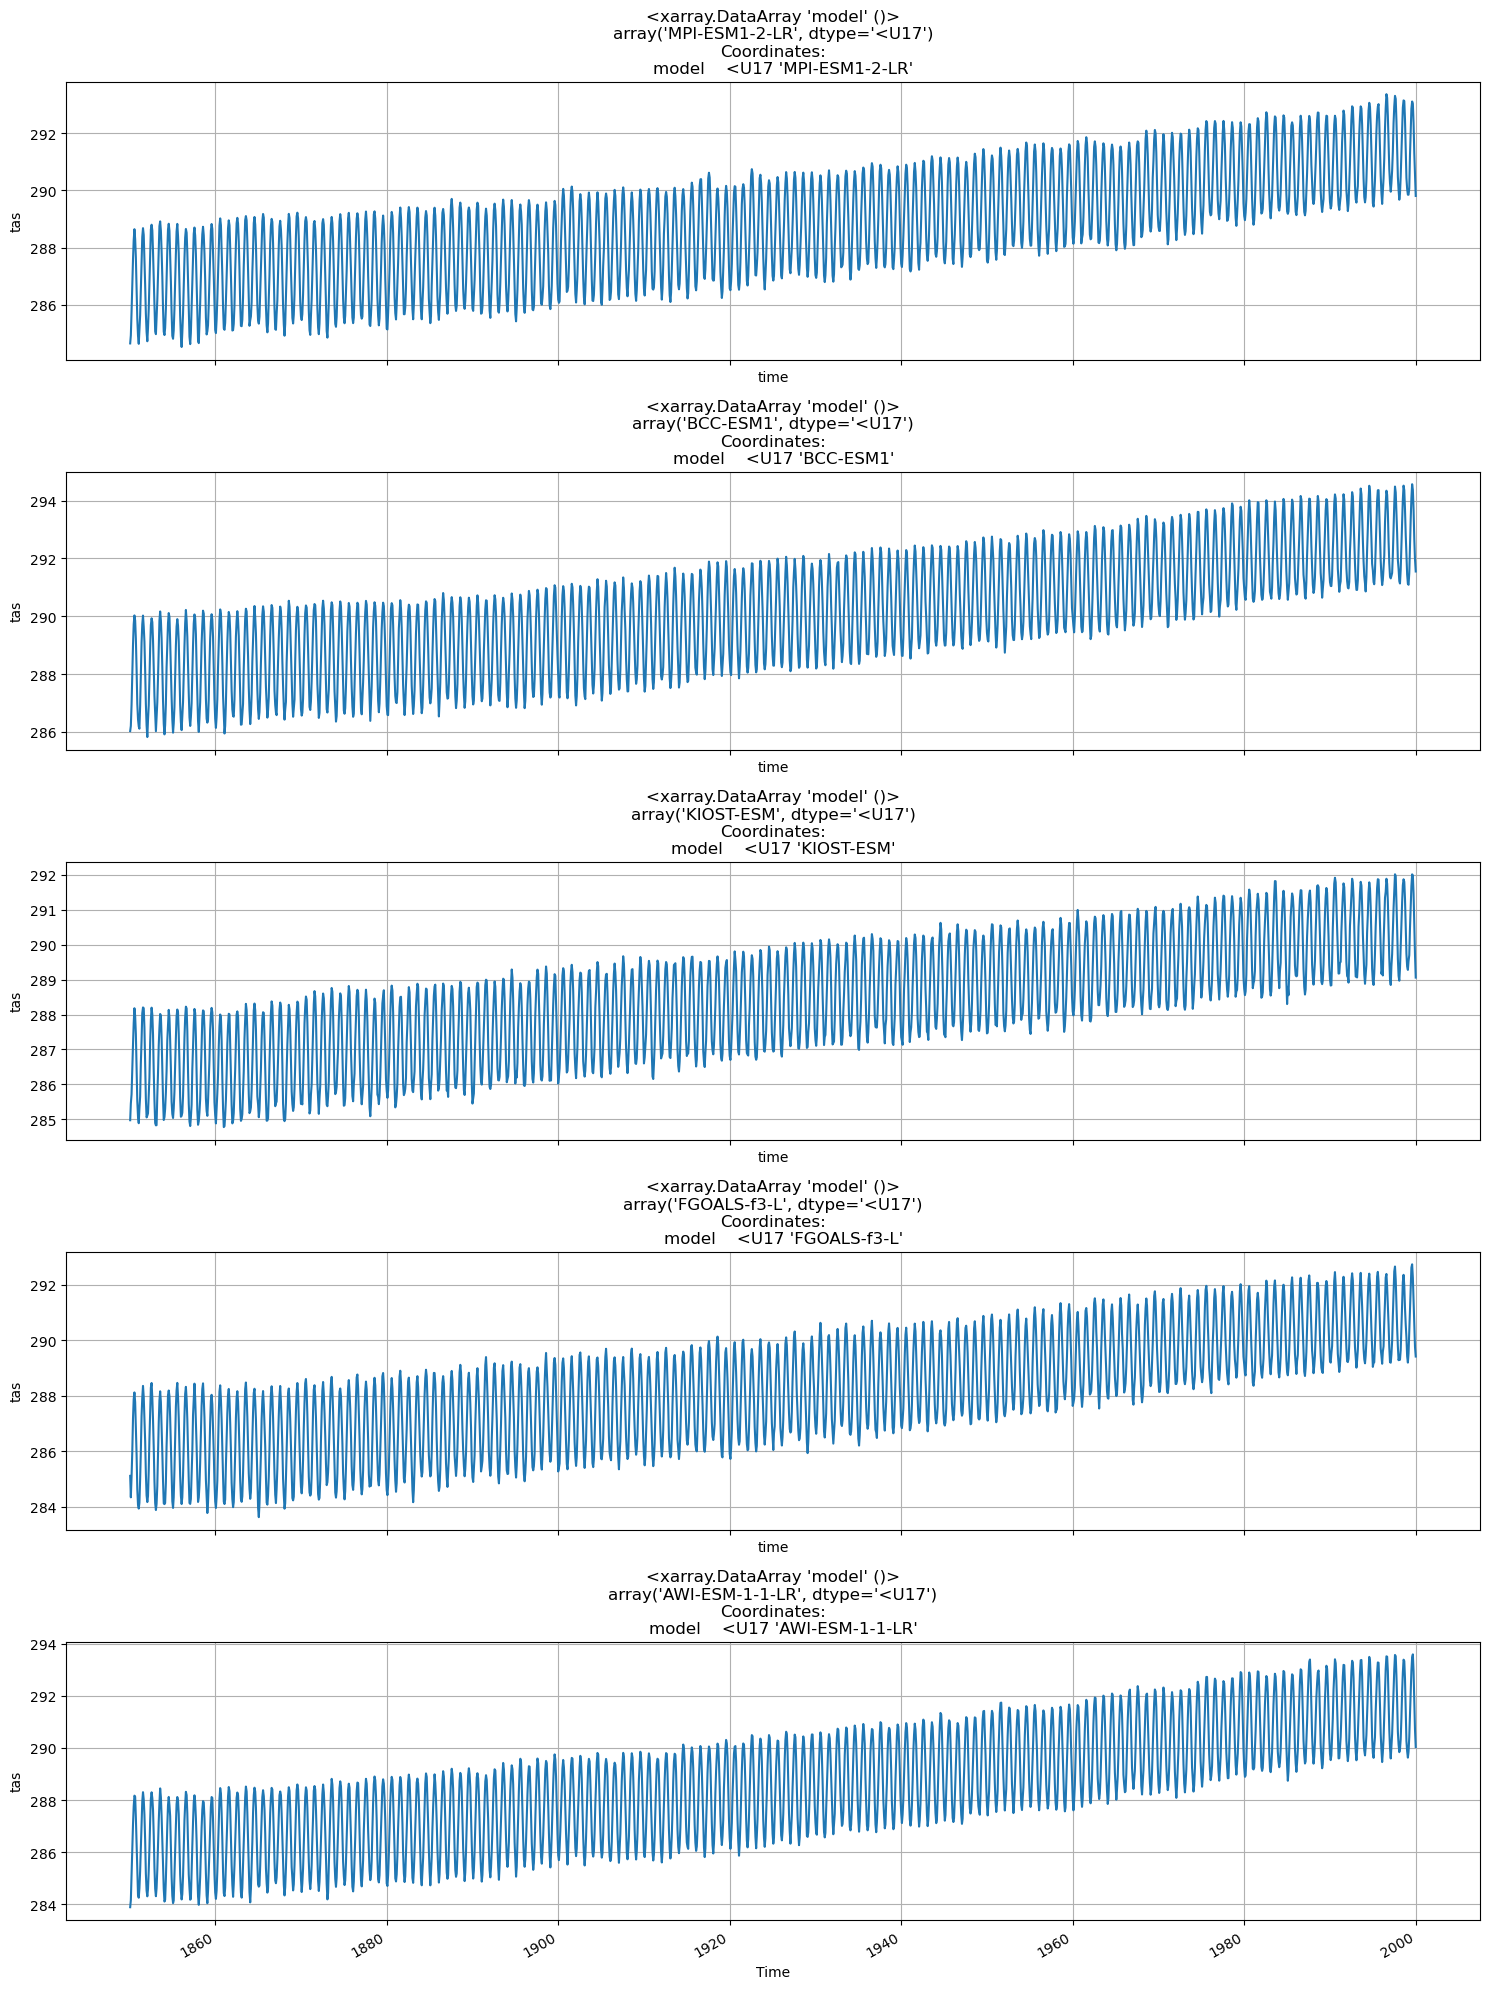

In [132]:
plot_time_series(0,5,25,ds_all_35)

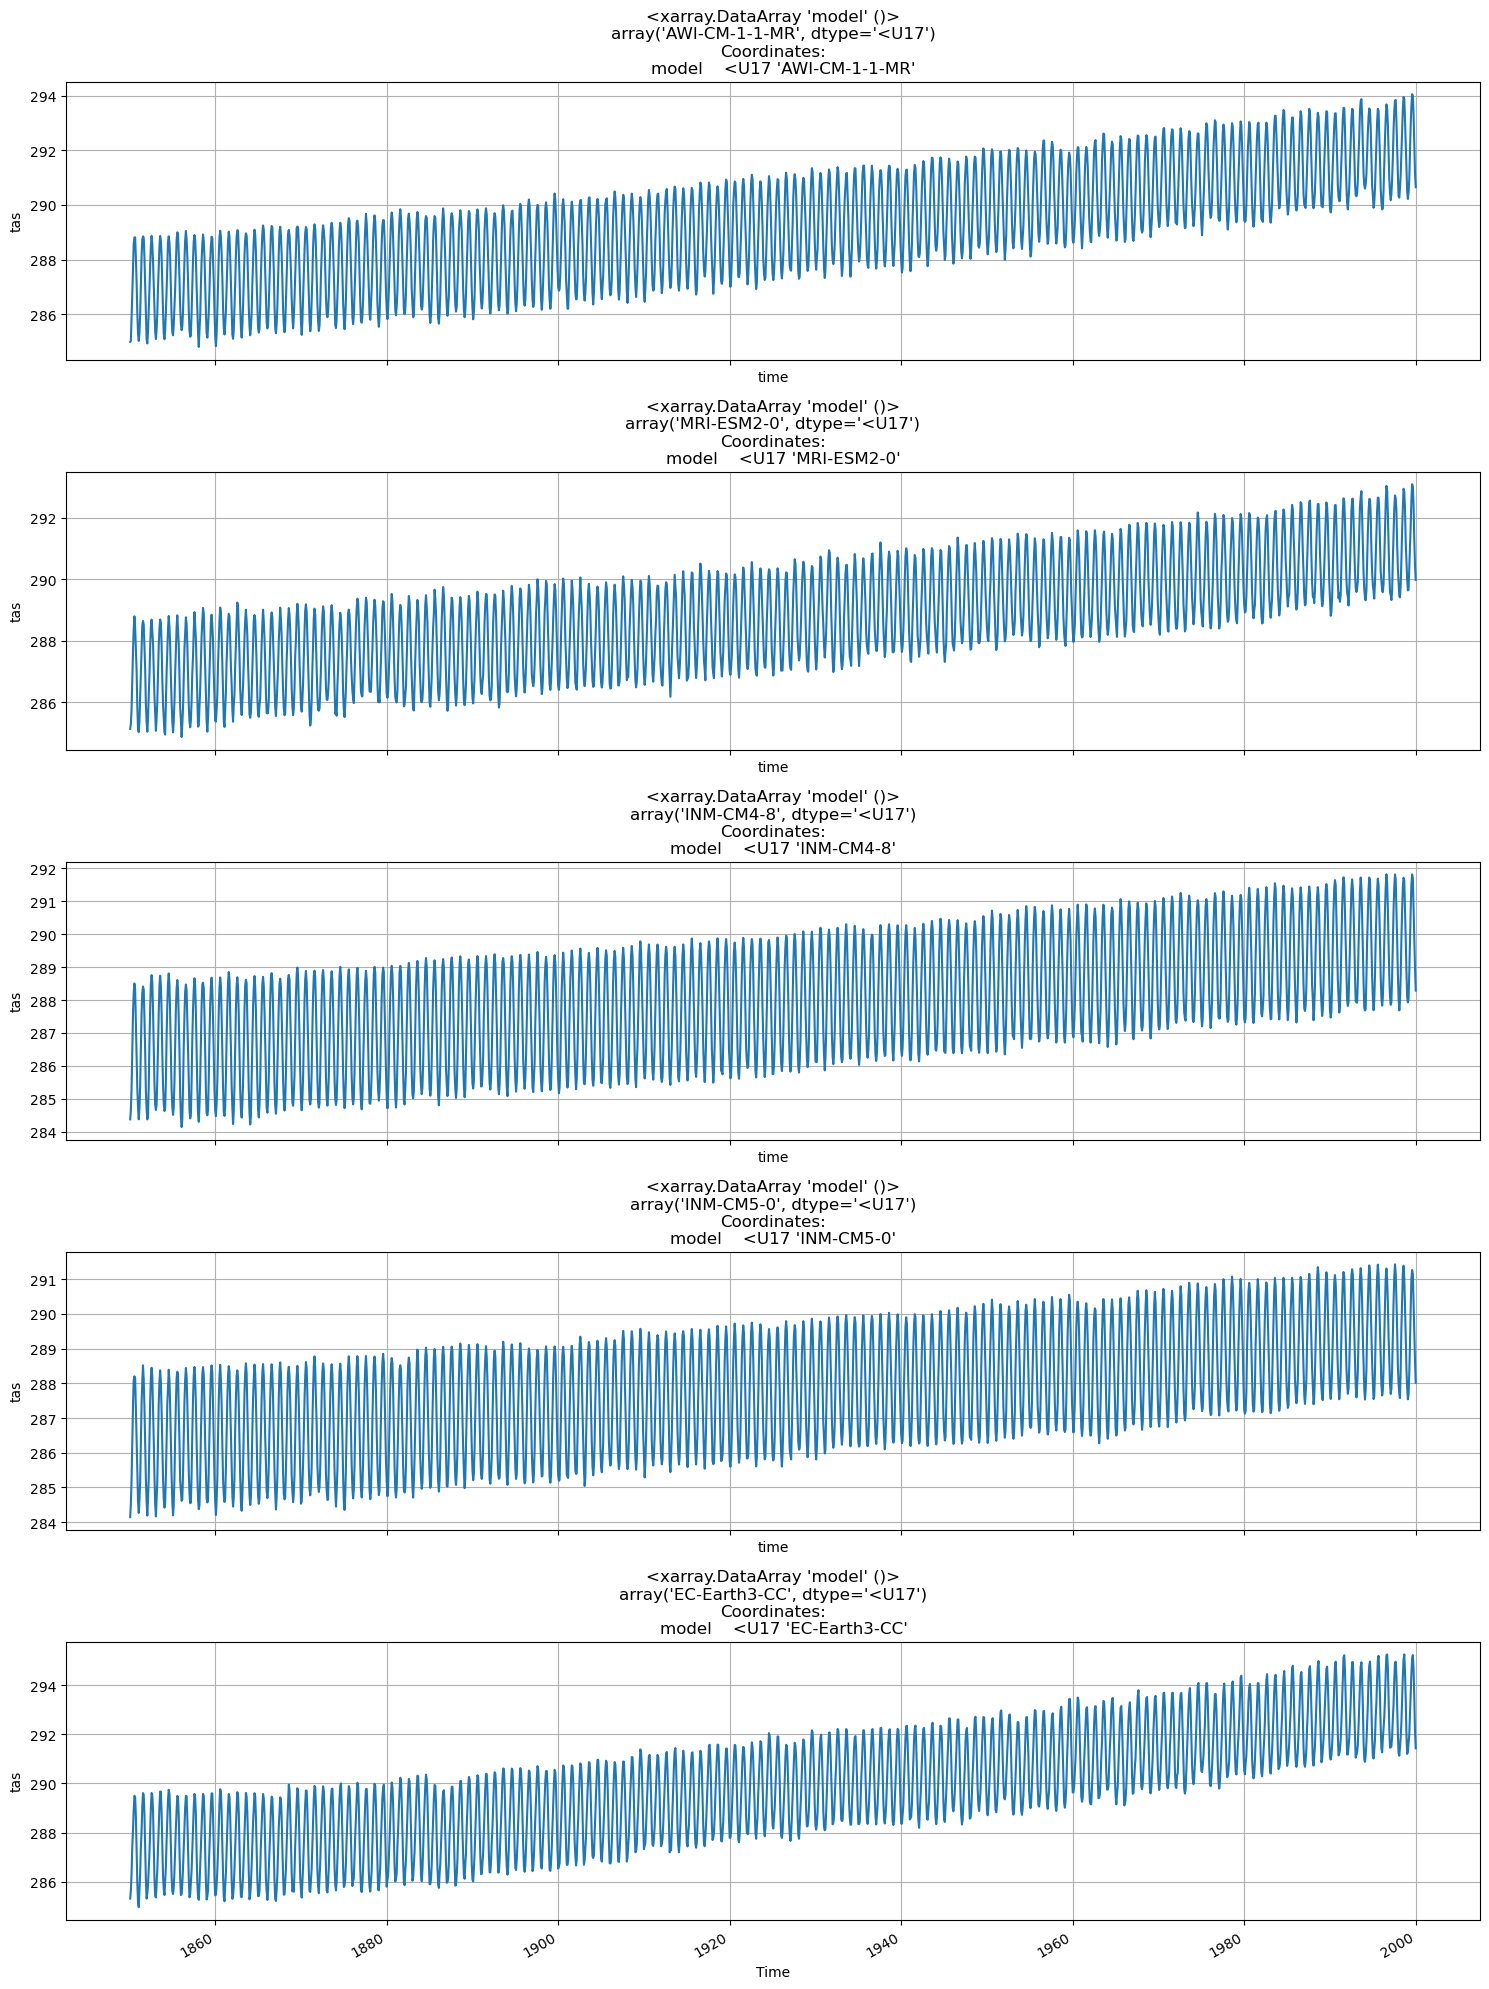

In [133]:
plot_time_series(0,5,30,ds_all_35)

### 1.3 Monthly Anomalies

In [26]:
#remove seasonal cycle
ds_all_models_anom = ds_all_35.tas.groupby('time.month') - ds_all_35.tas.groupby('time.month').mean('time')
#remove baseline: remove avg temp from 1850 to 1900
#ensure that what we are plotting are monthly anomalies relative to an 1850-1900 baseline
ds_all_models_anom = ds_all_models_anom - ds_all_models_anom.sel(time=slice('1850','1900')).mean('time')
ds_all_models_anom

C:\Users\panda\miniconda3\envs\temp_var\Lib\site-packages\xarray\core\indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 150 times more chunks
  return self.array[key]


<xarray.DataArray 'tas' (model: 35, time: 1800)>
dask.array<sub, shape=(35, 1800), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1850-01-31 1850-02-28 ... 1999-12-31
  * model    (model) <U17 'CanESM5-CanOE' 'UKESM1-0-LL' ... 'IPSL-CM6A-LR'
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

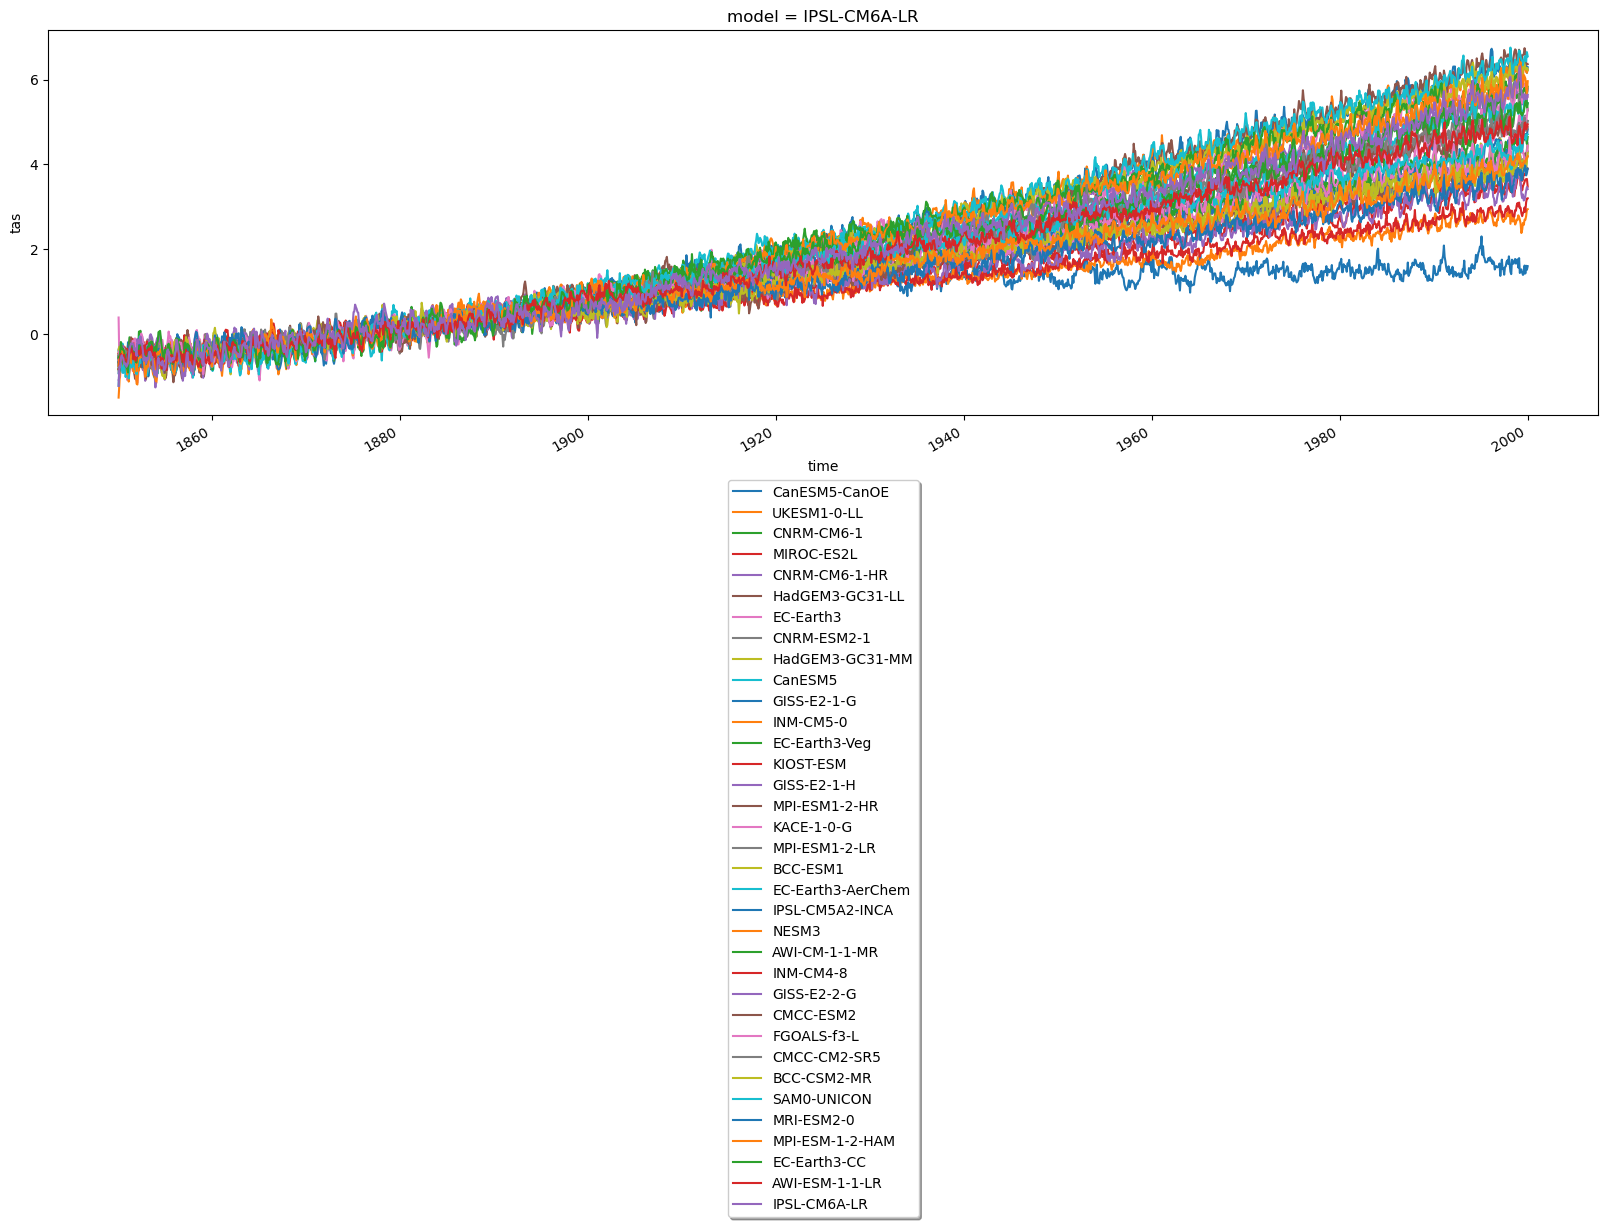

In [27]:
fig, ax = plt.subplots(figsize=(20,5))
# Plot each line separately and collect the lines and labels
handles = []
labels = []
for m in ds_all_models_anom.model.values:
    line = ds_all_models_anom.sel(model=m).plot.line(ax=ax, x='time', hue='model', add_legend=False)
    handles.append(Line2D([], [], color=line[0].get_color(), label=m))  # Create Line2D handle
    labels.append(m)
ax.legend(handles=handles, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True)

In [29]:
ds_all_35.to_netcdf("processed_tas_global_1pctCO2_data.nc", mode = 'w', format = "NETCDF4", engine = 'netcdf4')